# Classification. Linear models and KNN

In [473]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [474]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from numpy import linalg as LA

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [475]:
from sklearn.exceptions import NotFittedError

In [476]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init

        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1 / (1 + np.exp(-X @ weights.T))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        N = x.shape[0]
        sum = 0
        for i in range(N):
            sum += np.log(1 + np.exp(-(np.sum(weights.T @ x[i])) * y[i])) 
            
        loss = (1 / N) * sum + LA.norm(weights)**2/(2* self.C)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            sum = 0
            N = X_ext.shape[0]
            for j in range(N):
                sum += y[j] * X_ext[j] * (1 - 1/(1 + np.exp(-(np.sum(self.weights_.T @ X_ext[j])) * y[j]))) 
            delta = - sum/N + self.weights_ / self.C
            
            self.weights_ -= self.eta * delta

            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            if i >= self.max_iter or np.linalg.norm(self.weights_ - self.zero_init) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        preds = self.predict_proba(X)
        return [1 if i >= 0.5 else -1 for i in preds]

In [477]:
from sklearn import datasets
from sklearn import metrics

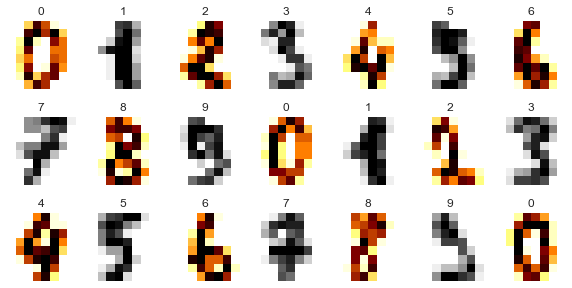

In [478]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [479]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [480]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [481]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [482]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [483]:
lr_clf.fit(X_train, y_train)

In [484]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [485]:
model = CustomLogisticRegression()

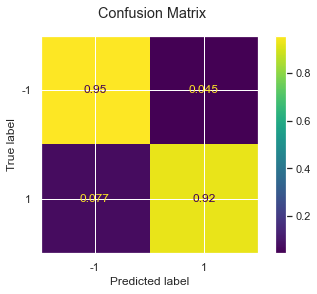

In [486]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [487]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [488]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

<AxesSubplot:>

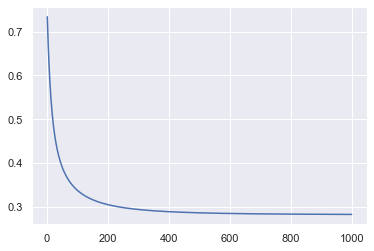

In [489]:
x = range(1, len(model.loss_history)+1)
sns.lineplot(x=[*x], y=model.loss_history)

Как можно увидеть из графика выше, значение Loss уменьшается с каждым шагом. Сначало значительно, потом все меньше и меньше.

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

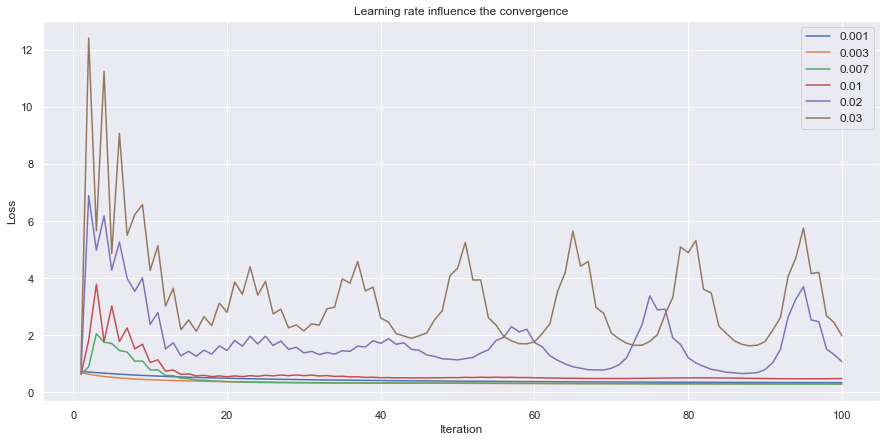

In [490]:
## your code
lerning_rates = [0.001, 0.003, 0.007, 0.01, 0.02, 0.03]
plt.figure(figsize=(15,7))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Learning rate influence the convergence')

for eta in lerning_rates:
    model = CustomLogisticRegression(max_iter=100, eta = eta)
    model.fit(X_train, y_train)
    x = range(1, len(model.loss_history)+1)
    sns.lineplot(x=[*x], y=model.loss_history)  

plt.legend(labels=lerning_rates, loc='best', fontsize=12)

Увеличение learning rate ускоряет сходимость функции. Однако после определенного learning rate loss будет расти, и функция начнет расходиться, алгоритм будет как бы перепрыгивать через минимум, а потом обратно к нему возвращаться. Эти скачки отчетливо видны для lr = 0.03, 0.02.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [491]:
def get_accuracy_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

<AxesSubplot:xlabel='Regularization param', ylabel='Accuracy'>

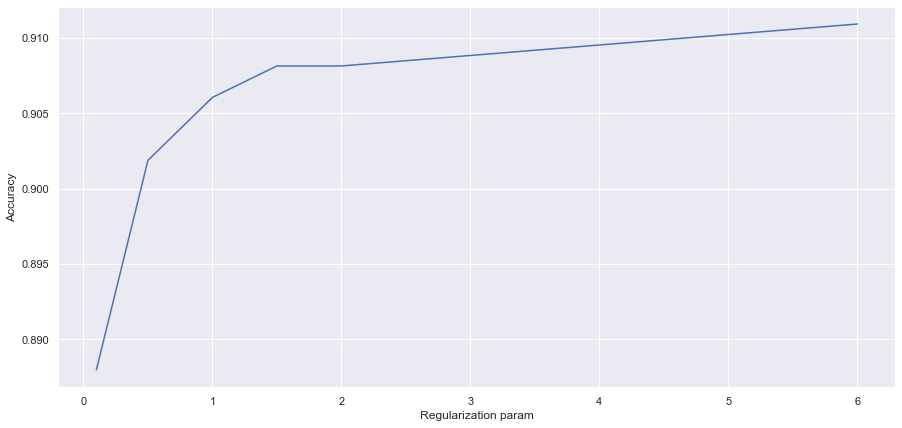

In [492]:
plt.figure(figsize=(15,7))
plt.xlabel('Regularization param')
plt.ylabel('Accuracy')

regularization_params = [0.1, 0.5, 1, 1.5, 2, 6]
results = []

for reg in regularization_params:
    model = CustomLogisticRegression(max_iter=500, C = reg)
    result_train, reult_test = get_accuracy_score(model, X_train, y_train, X_test, y_test)
    results.append(result_train)

sns.lineplot(x=regularization_params, y=results)

Можно заметить, что с увеличением параметра регулязации растет и accuracy.

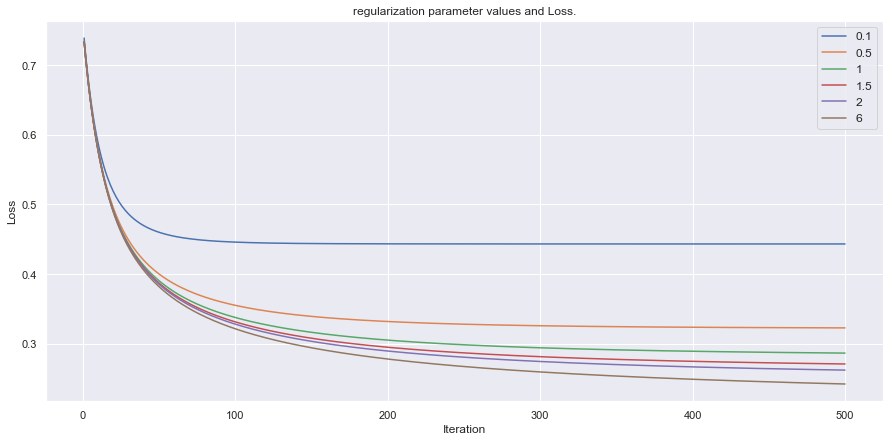

In [493]:
plt.figure(figsize=(15,7))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('regularization parameter values and Loss.')

for reg in regularization_params:
    model = CustomLogisticRegression(max_iter=500, C = reg)
    model.fit(X_train, y_train)
    x = range(1, len(model.loss_history)+1)
    sns.lineplot(x=[*x], y=model.loss_history)  

plt.legend(labels=regularization_params, loc='best', fontsize=12)

С увеличением параметра регулязации Loss падает быстрее и достигает меньшего значения. Можно сделать вывод, что параметр регулязации помогет достичь лучшее решение.

**(0.5 points)** Compare zero initialization and random initialization. 

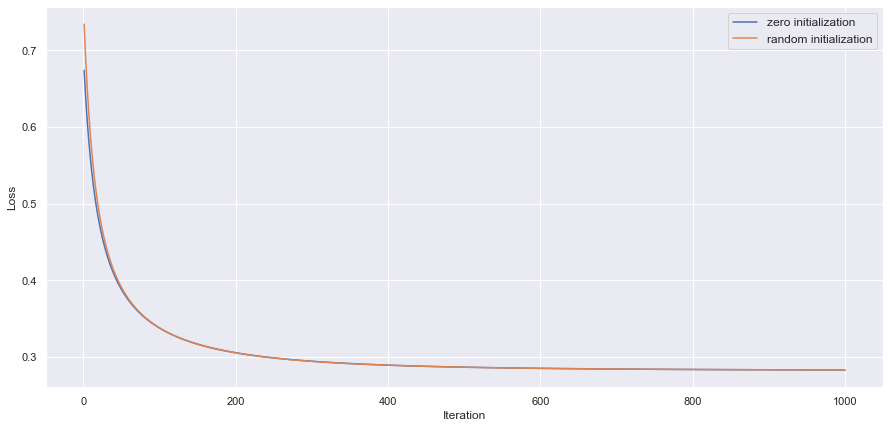

In [494]:
## your code
plt.figure(figsize=(15,7))
plt.xlabel('Iteration')
plt.ylabel('Loss')
model_zero = CustomLogisticRegression(max_iter=1000, zero_init = True)
model_random = CustomLogisticRegression(max_iter=1000, zero_init = False)

model_zero.fit(X_train, y_train)
x_zero = range(1, len(model_zero.loss_history)+1)
sns.lineplot(x=[*x_zero], y=model_zero.loss_history)

model_random.fit(X_train, y_train)
x_random = range(1, len(model_random.loss_history)+1)
sns.lineplot(x=[*x_random], y=model_random.loss_history)
plt.legend(labels=['zero initialization' , 'random initialization'], loc='best', fontsize=12)

Как видно из графика выше, при инициализации нулями значение Loss в начале ниже, чем для рандомной инициализации, однако потом кривые сходятся. 

Можно сделать вывод, что инициализация влияет только на показатели в самом начале и дальше показатели выравниваются. Лично я бы выбирала рандомную инициализацию небольшими коэффициентами. 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [495]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = [
            [np.sqrt(np.sum(np.square(x_item - y_item))) for y_item in Y]
            for x_item in X
        ]

        return np.array(P)
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        P = []
        for class_item in self.classes_:
            weight = 0
            for i in range(len(y)):
                if class_item == y[i]:
                    weight += weights[i]
            P.append(weight)           

        return np.array(P)
            
    def get_weights(self, P):
        # You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment),
        #  you can set the weights inversely proportional to that distance.
        weights = [
            (1 / (dist + self.eps))
            for dist in P
        ]

        return weights

    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
    # (360, 64)
    # (360, 1437)
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            predicted = []
            for i in range(len(P)):
                p = P[i]
                weights_of_points = np.ones(P.shape)
                if self.weights == 'distance':
                    k_neighbors_indexes = np.argpartition(p, self.n_neighbors)[:self.n_neighbors]
                    other_indexes = np.setdiff1d(range(len(p)), k_neighbors_indexes)
                    p[other_indexes] = np.inf
                    
                    weights_of_points = self.get_weights(p)
                    class_weights = self.get_class_weights(self.y, weights_of_points)
                    probabilites = np.divide(class_weights, np.sum(class_weights))
                    predicted.append(probabilites)
                
            return predicted
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        probabilities = self.predict_proba(X)
        result = [np.argmax(probabilities[i], axis=-1) for i in range(len(probabilities))]
        return result

In [496]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [497]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [498]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

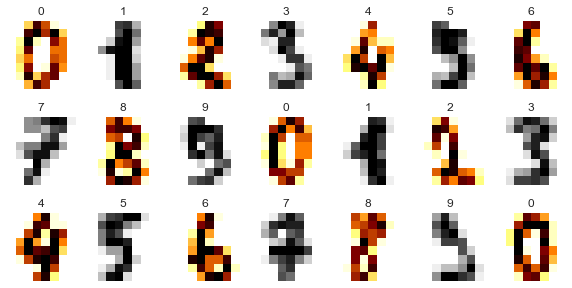

In [499]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [500]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [501]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

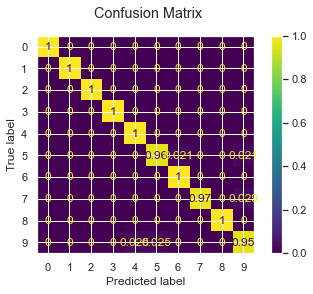

In [502]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [503]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

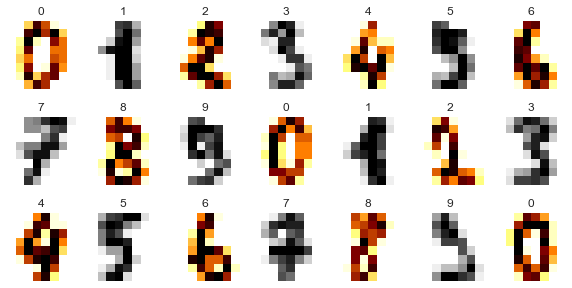

In [532]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

Алгоритм путает 5 с 6 и 9, 7 с 9, 9 с 4 и 5. Такое получается, потому что эти числа действительно похожи друг на друга (если взглянуть на их отображение выше) и их довольно просто спутать не только компьютеру, но и человеку.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

<AxesSubplot:xlabel='N value', ylabel='Accuracy'>

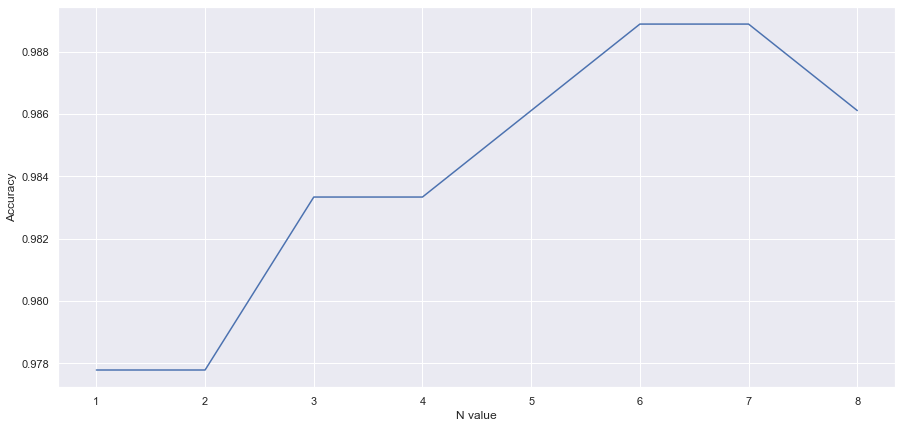

In [531]:
plt.figure(figsize=(15,7))
plt.xlabel('N value')
plt.ylabel('Accuracy')
n_params = [1, 2, 3, 4, 5, 6, 7, 8]
results_test = []

for n in n_params:
    model = CustomKNeighborsClassifier(n_neighbors=n, weights='distance')
    result_train, result_test = get_accuracy_score(model, X_train, y_train, X_test, y_test)
    results_test.append(result_test)

sns.lineplot(x=n_params, y=results_test)

Как мы можем заметить, лучшее значение N = 6 и 7. При значениях ниже 6 и выше 7 точность падает. 

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [505]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [506]:
PATH = "./data/train.csv/"

In [507]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [508]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [509]:
data.shape

(100000, 11)

In [510]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


In [511]:
titanic_data_female = data[data['Sex'] == 'female']
titanic_data_male = data[data['Sex'] == 'male']

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [512]:
print('Count of male in the dataset: ' + str(data[data['Sex'] == 'male'].shape[0]))
print('Count of female in the dataset: ' + str(data[data['Sex'] == 'female'].shape[0]))

Count of male in the dataset: 56114
Count of female in the dataset: 43886


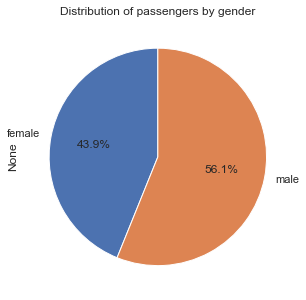

In [513]:
data.groupby('Sex').size().plot.pie(y='Sex',figsize=(5, 5),autopct='%1.1f%%', startangle=90) \
.set_title('Distribution of passengers by gender')
plt.show()

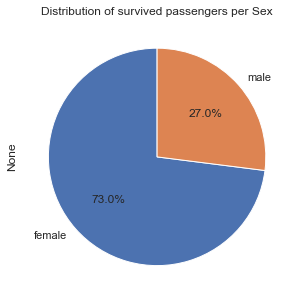

In [514]:
survived = data[data['Survived'] == 1].groupby('Sex').size()
survived.plot.pie(y='Sex',figsize=(5, 5),autopct='%1.1f%%', startangle=90) \
.set_title('Distribution of survived passengers per Sex')
plt.show()

Можно заметить, что женщин выжило в 2 раза больше, значит пол очень сильно влиял на выживаемость. Скорее всего это из-за того, что спасали в первую очередь женщин и детей.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [515]:
data[data['Survived'] == 1]['Age'].describe()

count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

In [516]:
data[data['Survived'] == 0]['Age'].describe()

count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64

Text(0.5, 1.0, 'Age distribution of the passengers')

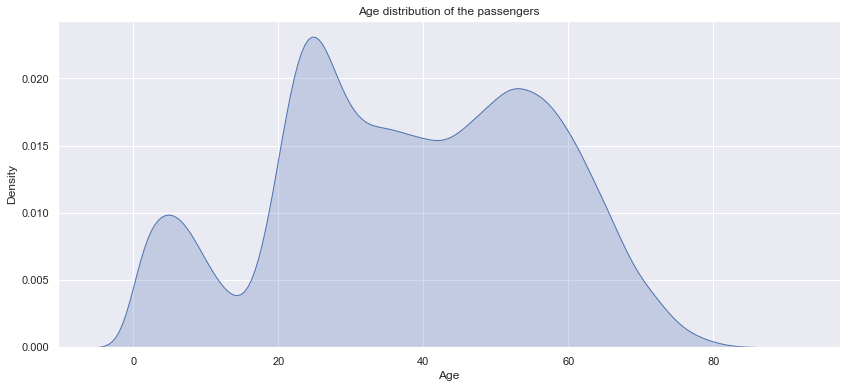

In [517]:
plt.figure(figsize=(14,6))
sns.set_theme()
sns.kdeplot(data=data['Age'], shade=True).set_title('Age distribution of the passengers')

Как видим из графика выше, наибольше количество пассажиров было в возрасте от 25 до 50.

Самому старшему пассажиру было 87 лет. Самому младшему 0.08 лет.

Text(0.5, 1.0, 'The relationship between Age and chance to survive')

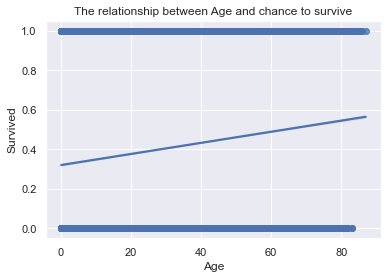

In [518]:
sns.regplot(x=data['Age'], y=data['Survived']).set_title('The relationship between Age and chance to survive')

Text(0.5, 1.0, 'The relationship between Age, Sex and chance to survive')

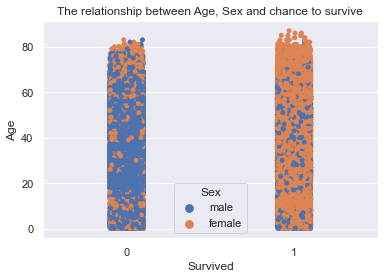

In [519]:
sns.stripplot(data=data, x="Survived", y="Age", hue = "Sex").set_title('The relationship between Age, Sex and chance to survive')

Возраст влиял на выживаемость, но намного меньше, чем пол.

Давайте сгруппируем возраста и посмотрим на результат

In [520]:
def add_age_status(x):
    age=x['Age']
    if age <= 2:
        return 'Babies'
    elif age <= 14:
        return 'Children'
    elif age <= 24:
        return 'Youth'
    elif age <= 60:
        return 'Adults'
    else:
        return 'Seniors'
    
data['Age_Status'] = data.apply(add_age_status, axis=1)

[Text(0.5, 1.0, 'The relationship between Sex, Age status and chance to survive')]

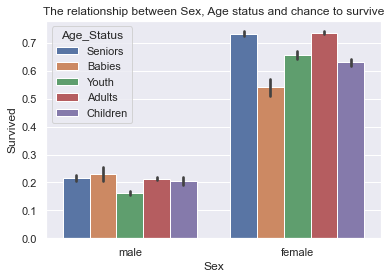

In [521]:
sns.barplot(x = 'Sex', y ='Survived', hue='Age_Status', data = data).set(title='The relationship between Sex, Age status and chance to survive')

Возраст действительно влиял на выживаемость. Мы видим, что с возрастом выживаемость женщин немного увеличивалась, меньше всего выжило маленьких детей среди женщин и молодых людей среди мужин, а больше пожилых женщин и детей до 2 лет среди мужчин. Многие мужчины в не зависисомти от их возраста выжили, хотя должны были спасаться последними.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

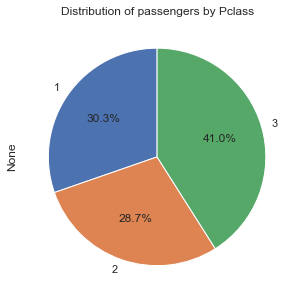

In [522]:
data.groupby('Pclass').size().plot.pie(y='Pclass',figsize=(5, 5),autopct='%1.1f%%', startangle=90) \
.set_title('Distribution of passengers by Pclass')
plt.show()

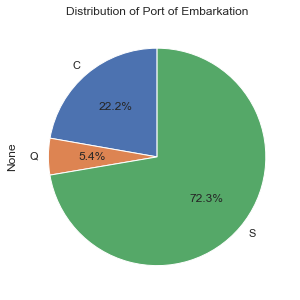

In [523]:
data.groupby('Embarked').size().plot.pie(y='Embarked',figsize=(5, 5),autopct='%1.1f%%', startangle=90).set_title('Distribution of Port of Embarkation')
plt.show()

Text(0.5, 1.0, 'The relationship between Pclass and chance to survive')

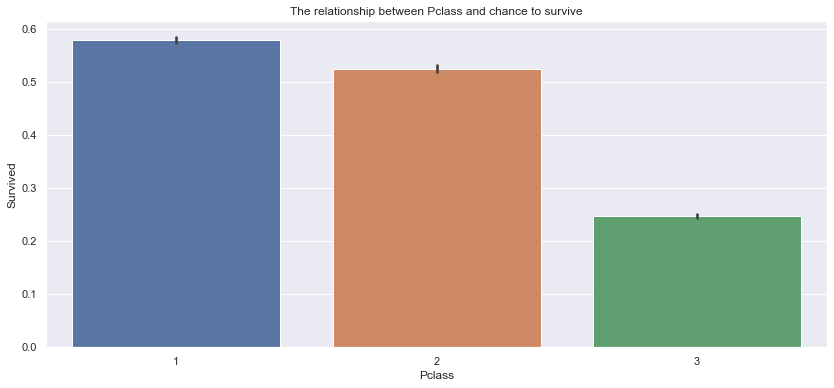

In [524]:
plt.figure(figsize=(14,6))
sns.barplot(x = 'Pclass', y ='Survived', data = data).set_title('The relationship between Pclass and chance to survive')

Таким образом, мы видим, что чем выше класс, тем выше вероятность выживания.

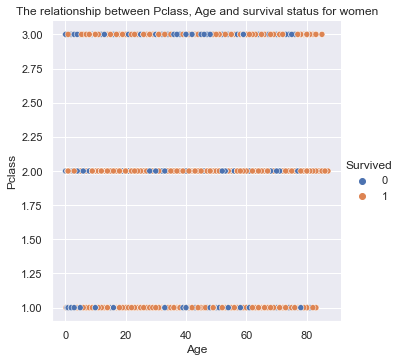

In [525]:
sns.relplot(x="Age", y="Pclass", hue="Survived", data=titanic_data_female).set(title='The relationship between Pclass, Age and survival status for women')

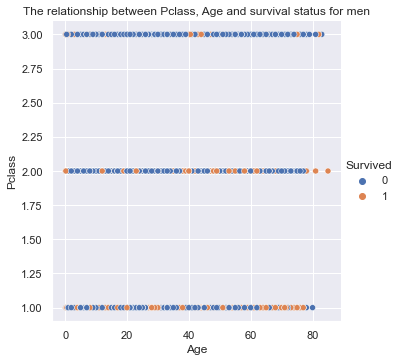

In [526]:
sns.relplot(x="Age", y="Pclass", hue="Survived", data=titanic_data_male).set(title='The relationship between Pclass, Age and survival status for men')

Из приведенных графиков видно, что шансы на выживание у женщин первого и второго класса гораздо выше.

Выглядит немного странно, потому что выжили почти все мужчины из первого класса в возрасте 60-80 лет. Детей же мужского пола не выжило значительно больше для всех классов.

[Text(0.5, 1.0, 'The relationship between port of landing and chance to survive')]

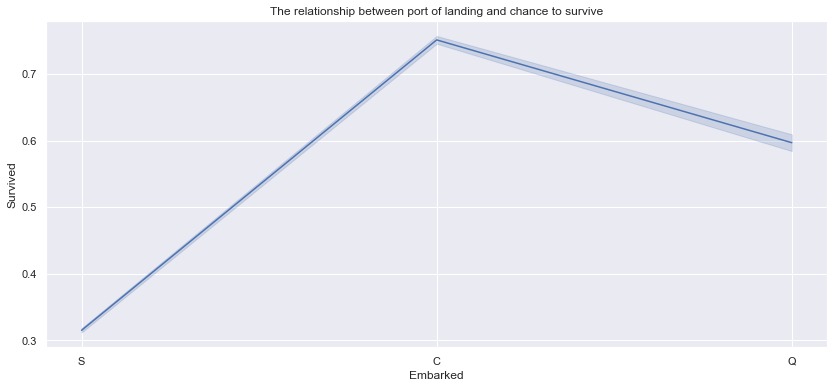

In [527]:
#C = Cherbourg, Q = Queenstown, S = Southampton
plt.figure(figsize=(14,6))
sns.lineplot(x='Embarked', y='Survived', data=data).set(title='The relationship between port of landing and chance to survive')

На первый взгляд можно заметить, что больше всего шансов выжить было у тех, кто отплыл из порта Cherbourg.

<Figure size 1008x432 with 0 Axes>

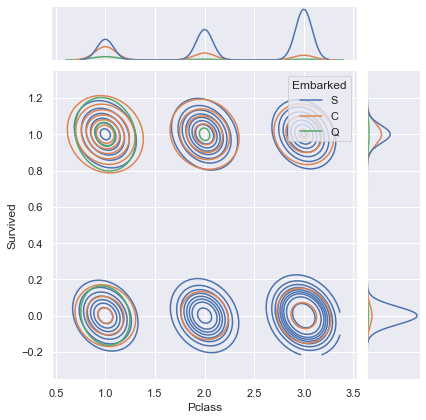

In [528]:
plt.figure(figsize=(14,6))

sns.jointplot(
    data=data,
    x="Pclass", y="Survived", hue="Embarked",
    kind="kde")

Приведенный выше график показывает, что связь между портом посадки и выживаемостью возникла из-за соотношения порта и класса.

Таким образом первый класс существенно улучшал выживаемость, порт посадки тоже имел какое-то воздествие, но в первую очередь из-за того, что некоторые классы садились в определенных портах.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [529]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column': data.columns, '% missing': percent_missing})

print(missing_value_df)

                column  % missing
Survived      Survived      0.000
Pclass          Pclass      0.000
Name              Name      0.000
Sex                Sex      0.000
Age                Age      3.292
SibSp            SibSp      0.000
Parch            Parch      0.000
Ticket          Ticket      4.623
Fare              Fare      0.134
Cabin            Cabin     67.866
Embarked      Embarked      0.250
Age_Status  Age_Status      0.000


In [534]:
def substrings_in_string(big_string, substrings):
    res = list(filter(lambda x:  x in big_string , substrings))
    return str(res[0]) if res else 'Unknown'

cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
data['Deck']=data['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
data['Is_Deck_Unknown']=data['Deck'] == 'Unknown'

[Text(0.5, 1.0, 'The relationship between Is_Deck_Unknown and chance to survive')]

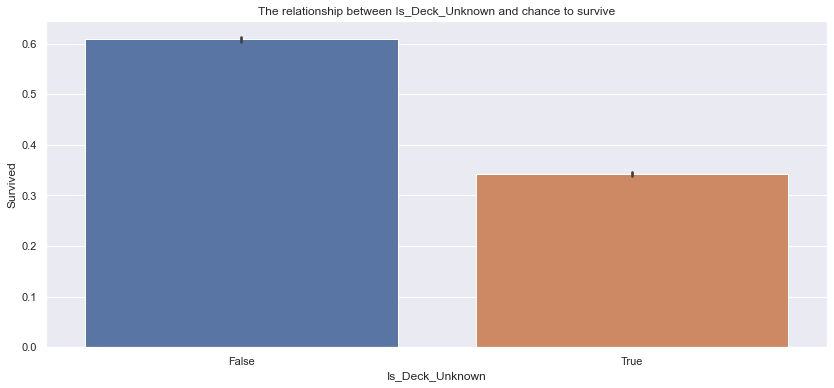

In [535]:
plt.figure(figsize=(14,6))
sns.barplot(x = 'Is_Deck_Unknown', y ='Survived', data = data).set(title='The relationship between Is_Deck_Unknown and chance to survive')

Мы видим, что люди, чьи номера кают известны, имеют больше шансов выжить. Это может быть связано с тем, что номер каюты был сообщен выжившими пассажирами после крушения.

Есть несколько вариантов, как избавиться от пустых значений:

        1) Просто удалить записи, где есть пустые колонки Age, Ticket, Fare, Embarked. Данных много, а процент пропусков небольшой, поэтому это может быть вполне себе приемлимый вариант. Однако могут быть какие-то важные зависимости от того заполнены ли какие-то данные или нет (как на графике выше с пропущенной кабиной)
        
        2) Заполнить средними значениями. Вариант не сильно лучше пердыдущего в данном случае. Пользы от таких данных будет не сильно много.
        
        3) Найти какие-то зависимости, разбить данные на кластеры и заполнить. Лучший варинт, но наиболее времязатратный.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Добавим новые фичи

In [ ]:
data['Family_Size']=data['SibSp']+data['Parch']
data['Fare_Per_Person']=data['Fare']/(data['Family_Size']+1)
data['Is_Family_On_Board']=data['Family_Size'] > 0

def titles_in_name(big_string, substrings):
    res = list(filter(lambda x: bool(re.search(r"\b(" + x + r"\.)\s", big_string)), substrings))
    return str(res[0]) if res else 'Unknown'

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer', 'Lady', 'Sir']

def replace_titles(x):
    title=x['Title']
    if title in ['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir', 'Countess']:
        return 'Aristocratic'
    if title in ['Mlle', 'Mme']:
        return 'Miss'
    if title in ['Ms']:
        return 'Mrs'
    else:
        return title
data['Title']=data['Name'].map(lambda x: titles_in_name(str(x), title_list))
data['Title']=data.apply(replace_titles, axis=1)

In [ ]:
## your code

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.